### Importing the libraries

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from diffusers import DPMSolverMultistepScheduler, UNet2DModel
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt
import time

/home/asardesai/Projects/Causal-Diffusion-Model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Class Definitions

In [4]:
class AnnotationReader:
    '''Reads the Labels and maintains them in memory'''
    def __init__(self, filename):
        data = []
        indices = []
        with open(filename, 'r') as file:
            n_lines = int(file.readline())
            self.features = file.readline().split()
            for i in range(n_lines):
                line = file.readline().split()
                indices.append(line[0])
                data.append(line[1:])
        self.dataframe = pd.DataFrame(data, columns=self.features, index=indices)
    
    def __getitem__(self, idx):
        return self.dataframe.index[idx], self.dataframe.iloc[idx].to_dict()
    
    def __len__(self):
        return len(self.dataframe)

In [5]:
class CustomImageDataset(datasets.VisionDataset):
    '''Dataset that returns the image tensor and labels. Loads them from disk.'''
    def __init__(self, image_dir, annotation_file, transform=None):
        self.annotations = AnnotationReader(annotation_file)
        self.image_dir = image_dir
        self.transform = transform
        super().__init__(image_dir, transform=transform)

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_file, labels = self.annotations.__getitem__(idx)
        img_tensor = self.transform(Image.open(os.path.join(self.image_dir, img_file)).convert("RGB"))
        return img_tensor, labels

In [6]:
def visualize_image(image_tensor):
    '''Allows us to visualize an image tensor'''
    to_pil = ToPILImage()
    image_pil = to_pil(image_tensor)
    image_pil.thumbnail((128,128))
    return image_pil

### Hyperparameters

In [7]:
BATCH_SIZE = 1

### Initialize the DataLoader

torch.Size([3, 1024, 1024])
{'5_o_Clock_Shadow': '-1', 'Arched_Eyebrows': '1', 'Attractive': '1', 'Bags_Under_Eyes': '1', 'Bald': '-1', 'Bangs': '-1', 'Big_Lips': '1', 'Big_Nose': '-1', 'Black_Hair': '-1', 'Blond_Hair': '-1', 'Blurry': '-1', 'Brown_Hair': '1', 'Bushy_Eyebrows': '1', 'Chubby': '-1', 'Double_Chin': '-1', 'Eyeglasses': '-1', 'Goatee': '-1', 'Gray_Hair': '-1', 'Heavy_Makeup': '1', 'High_Cheekbones': '1', 'Male': '-1', 'Mouth_Slightly_Open': '1', 'Mustache': '-1', 'Narrow_Eyes': '-1', 'No_Beard': '1', 'Oval_Face': '-1', 'Pale_Skin': '-1', 'Pointy_Nose': '1', 'Receding_Hairline': '-1', 'Rosy_Cheeks': '-1', 'Sideburns': '-1', 'Smiling': '1', 'Straight_Hair': '-1', 'Wavy_Hair': '1', 'Wearing_Earrings': '-1', 'Wearing_Hat': '-1', 'Wearing_Lipstick': '1', 'Wearing_Necklace': '-1', 'Wearing_Necktie': '-1', 'Young': '1'}


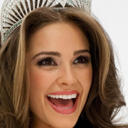

In [8]:
transform = transforms.Compose([
    transforms.Resize(1024),
    transforms.CenterCrop(1024),
    transforms.ToTensor(),
])

# Instantiate Dataset Object
dataset = CustomImageDataset('CelebAMask-HQ/CelebA-HQ-img', 'CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt', transform=transform)
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Test the dataset
img, labels = dataset.__getitem__(0)
print(img.shape)
print(labels)
visualize_image(img)



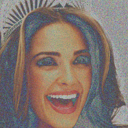

In [ ]:
device = torch.device("cuda:7") if torch.cuda.is_available() else 'cpu'

noise_scheduler = DPMSolverMultistepScheduler(num_train_timesteps=1000)
img2 = img.unsqueeze(0)
noise = torch.randn_like(img)
noisy_image = noise_scheduler.add_noise(img2, noise, torch.tensor([950]))
noisy_image = noisy_image[0]
visualize_image(noisy_image)

In [10]:
# @markdown Trying UNet2DModel instead of BasicUNet:


# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=1024,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

num_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {num_params / 1e6:.2f} million")

# Our loss function
loss_fn = torch.nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    i = 0
    for x, y in dataloader:
        i += 1
        start_time = time.time()
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape).to(device)  # Pick random noise amounts
        timestep = torch.randint(0, 1000, (BATCH_SIZE,)).to(device) # Pick a random timestep to train on
        noisy_x = noise_scheduler.add_noise(x, noise_amount, timestep) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, timestep).sample  # <<< Using timestep  always, adding .sample
        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        print(f"Iteration number: {i}")
        end_time = time.time()
        elapsed_time =  end_time - start_time
        estimated_training_time = 30000 * elapsed_time * 50 / 3600 / 24
        print(f"Estimated training time is: {int(estimated_training_time)} days")
        
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(dataloader) :]) / len(dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

Number of parameters: 1.54 million
Iteration number: 1
Estimated training time is: 243 days


KeyboardInterrupt: 